# Configuration

I am doing the part associated to finding new patterns

- The base queries that you need to edit: http://td.winnerstudio.vip:8996/#/tga/ide/59_28296?tab=result

-

In [2]:
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


In [3]:
# Load the DB connection keys
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script, bs_token, host):
    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 2000,
        'sql':            sql_script
    }
    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)
    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]
    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis = 1)
    return data



# Load

In [4]:
day = 7
version = 5

final_query = f"""

select *
from temp.acorn_temp_pay_withdraw_sequences_d{day}_v{version} a
    join temp.acorn_temp_playing_sequences_d{day}_v{version - 1} b    
        on a."#account_id" = b."#account_id"
    join temp.aggregate_bets_day_7_temp_v2 c  
        on a."#account_id" = c."#account_id"
"""

print(final_query)




select *
from temp.acorn_temp_pay_withdraw_sequences_d7_v5 a
    join temp.acorn_temp_playing_sequences_d7_v4 b    
        on a."#account_id" = b."#account_id"
    join temp.aggregate_bets_day_7_temp_v2 c  
        on a."#account_id" = c."#account_id"



In [5]:
# Create df by loading information and joining on account_id
df = pull_data(final_query, bs_token, host)
# df_d7 = df.copy(deep = True)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


In [6]:
df['disputes_d30'] = df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)
print(df['disputes_d30'].sum())
print(df['disputes_d30'].mean())
print(df.columns)
df.sample(3)

1129
0.008050255269387638
Index(['#account_id', '#account_id(2)', '#account_id(3)', '#event_time',
       'already_disputed', 'avg_bet', 'avg_bet_day_1', 'avg_bet_day_3',
       'avg_bet_day_7', 'avg_win_day_1', 'avg_win_day_3', 'avg_win_day_7',
       'bet_money', 'bundle_id', 'disputable_payment', 'disputed_amount_d30',
       'disputes_d30', 'first_pay_time', 'flag', 'hours_first_payment',
       'lost_money_history', 'max_bet', 'max_bet_day_1', 'max_bet_day_3',
       'max_bet_day_7', 'max_win_day_1', 'max_win_day_3', 'max_win_day_7',
       'num_money_games', 'payment_d7', 'payment_enter_history',
       'payment_history', 'payment_history_time', 'payment_methods_score',
       'payment_methods_sequence', 'sum_bet_day_1', 'sum_bet_day_3',
       'sum_bet_day_7', 'sum_win_day_1', 'sum_win_day_3', 'sum_win_day_7',
       'withdraw_history', 'withdraw_history_time'],
      dtype='object')


,#account_id,#account_id(2),#account_id(3),#event_time,already_disputed,avg_bet,avg_bet_day_1,avg_bet_day_3,avg_bet_day_7,avg_win_day_1,...,payment_methods_score,payment_methods_sequence,sum_bet_day_1,sum_bet_day_3,sum_bet_day_7,sum_win_day_1,sum_win_day_3,sum_win_day_7,withdraw_history,withdraw_history_time
23293,10757149,10757149,10757149,2024-05-12 21:58:36.545,0,"[None, 0.2, None]",0.200000,0.200000,0.200000,-0.066667,...,1,[checkout_apple_pay],11.40,11.40,11.40,-3.80,-3.80,-3.80,NaN,NaN
103021,10252851,10252851,10252851,2024-02-03 16:35:12.961,0,"[0.57, 0.11, 0.12, 0.1, 0.1, None]",0.245038,0.245038,0.245038,-0.126728,...,1,[checkout_apple_pay],159.52,159.52,159.52,-82.50,-82.50,-82.50,NaN,NaN
127402,10190360,10190360,10190360,2024-01-06 02:24:54.560,0,"[None, 0.58, 0.59, 0.5, None]",0.495419,0.495419,0.495419,-0.221766,...,1,[paypal_wallet_slave],330.94,330.94,330.94,-148.14,-148.14,-148.14,NaN,NaN


In [7]:

# Function to convert the string list to a list of datetime objects
def convert_to_datetime_list(string):

    string = str(string).strip('[]').replace("'", '"').replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    return pd.to_datetime(date_strs, format = '%Y-%m-%d %H:%M:%S.%f')

# Apply the conversion
df['payment_history_time_clean'] = df['payment_history_time'].apply(convert_to_datetime_list)
df['withdraw_history_time_clean'] = df['withdraw_history_time'].apply(convert_to_datetime_list)
df['payment_history_time_clean']


0         DatetimeIndex(['2024-01-06 13:39:08.549000', '...
1         DatetimeIndex(['2024-01-07 00:26:33.643000', '...
2         DatetimeIndex(['2024-01-06 23:36:21.445000', '...
3         DatetimeIndex(['2024-01-17 04:00:22.706000', '...
4         DatetimeIndex(['2024-02-13 17:48:15.091000', '...
                                ...                        
140239    DatetimeIndex(['2024-03-02 21:38:51.241000', '...
140240    DatetimeIndex(['2024-03-16 04:19:45.832000', '...
140241    DatetimeIndex(['2024-07-06 03:30:17.773000', '...
140242    DatetimeIndex(['2024-04-01 05:43:56.426000', '...
140243    DatetimeIndex(['2024-01-12 16:20:37.915000', '...
Name: payment_history_time_clean, Length: 140244, dtype: object

In [8]:

df['Number_payments'] = df['payment_history'].apply(lambda x: len(str(x).replace('[', '').replace(']', '').replace('null', 'NaN').split(','))).astype(float)

# Group by 'len' and calculate the sum of 'disputes_d30'
grouped_df = df.groupby('Number_payments')['disputes_d30'].sum().reset_index()
grouped_df_rate = df.groupby('Number_payments')['disputes_d30'].mean().reset_index()

# Calculate the total sum of 'disputes_d30'
total_sum = grouped_df['disputes_d30'].sum()

# Calculate the percentage
grouped_df['dispute_rate'] = (grouped_df_rate['disputes_d30'])
grouped_df['percentage'] = (grouped_df['disputes_d30'] / total_sum)

grouped_df.head(10)


,Number_payments,disputes_d30,dispute_rate,percentage
0,1.0,152,0.003209,0.134632
1,2.0,154,0.005102,0.136404
2,3.0,125,0.007637,0.110717
3,4.0,108,0.010607,0.095660
4,5.0,77,0.011314,0.068202
5,6.0,51,0.010410,0.045173
6,7.0,51,0.013600,0.045173
7,8.0,39,0.012953,0.034544
8,9.0,29,0.012457,0.025686
9,10.0,27,0.014354,0.023915


In [9]:
df['payment_history_values'] = df['payment_history'].astype(str).apply(lambda x: x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')).apply(lambda x: [float(val) for val in x])
# Calculate row-level statistics and create new columns
df['median_payment']  = df['payment_history_values'].apply(np.median)
df['average_payment'] = df['payment_history_values'].apply(np.mean)
df['maximum_payment'] = df['payment_history_values'].apply(np.max)
df['rel_maximum_payment'] = df['maximum_payment'] / df['average_payment']
df['minimum_payment'] = df['payment_history_values'].apply(np.min)

df['rel_payment_range'] = (df['maximum_payment'] - df['minimum_payment']) / df['minimum_payment']

payment_stats_colnames = [
    'median_payment',
    'average_payment',
    'maximum_payment',
    'rel_maximum_payment',
    'minimum_payment',
    'rel_payment_range'
]

# 1 Payments
## 1.1.
df['first_payment'] = df['payment_history'].astype(str).apply(lambda x: x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')[0]).astype(float)

# Function to extract the second payment safely
def extract_second_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[1])
    else:
        return np.nan

def extract_third_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[2])
    else:
        return np.nan

# Apply the function to create the 'second_payment' column
# 1.2 and 1.3
df['second_payment'] = df['payment_history'].astype(str).apply(extract_second_payment)
df['third_payment'] = df['payment_history'].astype(str).apply(extract_second_payment)

# Correct payment_enter_history
## 1.4
df['payment_enter_seq'] = df['payment_enter_history'].astype(str).str[1:-1].apply(lambda x: x.split(','))

# Compact the sequence to only the unique values
def get_unique_values(lst):
    return list(set(lst))

# 1.5
df['payment_enter_usage'] = df['payment_enter_seq'].apply(get_unique_values).astype(str)


In [10]:
columns_info = {'payment_enter_usage': 'items_list_'}

dummy_variable_list = []
for column, identifier in columns_info.items():

    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['disputes_d30'].sum()

    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 30].index.tolist()

    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)
list(final_dummy_variables.columns)


['items_list__["\'default\'", " \'default\'"]',
 'items_list__["\'default\'", " \'first_b\'", " \'default\'"]',
 'items_list__["\'default\'", " \'first_b\'", " \'start_pack\'", " \'default\'"]',
 'items_list__["\'default\'", " \'start_pack\'", " \'default\'"]',
 'items_list__["\'default\'"]']

In [11]:
df['default_flag'] = df['payment_enter_history'].apply(lambda row: 1 if 'default' in str(row) else 0)
df['lucky_flip'] = df['payment_enter_history'].apply(lambda row: 1 if 'lucky_flip' in str(row) else 0)
df['start_pack'] = df['payment_enter_history'].apply(lambda row: 1 if 'start_pack' in str(row) else 0)

cols_payment = ['default_flag', 'lucky_flip', 'start_pack']


In [12]:
# Time dynamics
def extract_datetime(x, index):
    dates = x  # Convert JSON string to list
    if len(dates) > index:
        return pd.to_datetime(str(dates[index])[1:-1])
    else:
        return np.nan

## 1.7 - 1.9
# df['first_datetime']  = df['payment_history_time'].astype(str).apply(lambda x: extract_datetime(x, 0))
df['first_datetime']  = df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]').apply(lambda x: extract_datetime(x, 0))
df['second_datetime'] = df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]').apply(lambda x: extract_datetime(x, 1))
df['third_datetime']  = df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]').apply(lambda x: extract_datetime(x, 2))
print('1.7 - 1.9')

# Apply the function to create new columns for minutes difference
def calculate_minutes_diff(start, end):
    if pd.notna(start) and pd.notna(end):
        return (end - start).total_seconds() / 60.0
    else:
        return np.nan

df['minutes_first_to_second'] = df.apply(lambda row: calculate_minutes_diff(row['first_datetime'], row['second_datetime']), axis=1)
df['minutes_second_to_third'] = df.apply(lambda row: calculate_minutes_diff(row['second_datetime'], row['third_datetime']), axis=1)
print('1-1.12')

1.7 - 1.9
1-1.12


In [13]:
## Growth
df['payment_history_time'] = df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')
df['payment_history_time'] = df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')
df['first_pay_time'] = pd.to_datetime(df['first_pay_time'])

# General function to extract the indexes of payments within a specified number of hours
def extract_within_hours(payment_times, first_pay_time, hours):
    # payment_times_list = [value[1:-1].strip("'") for value in payment_times]
    payment_times_list = payment_times
    payment_times_dt = pd.to_datetime(payment_times_list)
    return [i for i, time in enumerate(payment_times_dt) if time <= first_pay_time + pd.Timedelta(hours=hours)]

# General function to sum payments within specified hours using the extracted indexes
def sum_payments_within_hours(payment_history, indexes):
    payment_history = str(payment_history).strip('[]')
    payment_values_list = [str(item.strip()) for item in payment_history.split(',')]
    selected_payments = [float(payment_values_list[i].replace('[', '').replace(']', '')) for i in indexes
                            if i < len(payment_values_list)
                            and payment_values_list[i] is not None
                            and payment_values_list[i].replace('[', '').replace(']', '') != ''
                            and payment_values_list[i].replace('[', '').replace(']', '') != '.']

    return sum(selected_payments)

# Calculate sums for 24, 48, and 72 hours
for hours in [0.25, 0.5, 1, 6, 24, 48, 72, 96, 168]:
    print(hours)
    # print('2.2-2.10 - ', hours)
    col_index_name = f'indexes_within_{hours}_hours'
    col_sum_name = f'sum_payments_within_{hours}_hours'
    # df[col_index_name] = df.apply(lambda row: extract_within_hours(row['payment_history_time'], row['first_pay_time'], hours), axis=1)
    df[col_index_name] = df.apply(lambda row: extract_within_hours(row['payment_history_time_clean'], row['first_pay_time'], hours), axis=1)
    df[col_sum_name] = df.apply(lambda row: sum_payments_within_hours(row['payment_history'], row[col_index_name]), axis=1)
    df.drop(columns=[col_index_name], inplace=True)  # Drop the temporary column used for extracting indexes

# print('2.2-2.10')
print('2.2-2.10')

## Dispersion

## Amount per payments


0.25
0.5
1
6
24
48
72
96
168
2.2-2.10


In [14]:
df['sum_payments_within_6_hours'].fillna(1, inplace=True)

# Define the rounding set
rounding_set = np.array([20, 50, 100, 200, 300, 500])

# Function to round to the nearest value in the rounding set
def round_to_set(value, rounding_set):
    if value == 0:
        return 0
    return rounding_set[np.abs(rounding_set - value).argmin()]

# Iterate through columns to calculate percentual relative values
# previous_column = 'sum_payments_within_0.25_hours'
previous_column = 'sum_payments_within_24_hours'

columns = [
     # 'sum_payments_within_24_hours'
    'sum_payments_within_48_hours'
#     , 'sum_payments_within_48_hours'
    , 'sum_payments_within_48_hours'
    , 'sum_payments_within_72_hours'
    , 'sum_payments_within_96_hours'
    , 'sum_payments_within_168_hours']

for col in columns:
    if col.startswith('sum_payments_within_') and col != previous_column:
        # Calculate percentual relative values based on the previous column
        df[col + '_percentual'] = (df[col] - df[previous_column]) * 100 / df[previous_column]
        df[col + '_percentual'] = df[col + '_percentual'].apply(lambda x: round_to_set(x, rounding_set))
        # Update previous_column for the next iteration
        previous_column = col

df['payment_growth_shape'] = df.apply(lambda row: '_'.join([str(row[col]) for col in df.columns if col.endswith('_percentual')]), axis=1)

columns_info = {'payment_growth_shape': 'spending_growth_shape'}

dummy_variable_list = []
for column, identifier in columns_info.items():

    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['disputes_d30'].sum()

    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer == 0].index.tolist()

    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables_spending_growth_shape = pd.concat(dummy_variable_list, axis=1)

# Function to apply conditions
# def convert_value(value):
#     if value == '0_0_0':
#         return '0_0_0'
#     elif value == '200_20_0':
#         return '200_20_0'
#     else:
#         return 'others'

# # # Apply the function to the DataFrame column
# df['concatenated_column'] = df['concatenated_column'].apply(convert_value)
# df['concatenated_column']
print('2.10 - 2.20')

2.10 - 2.20


In [15]:
hours_columns = df.filter(regex = '_hours$').columns

# List to store new column names
rel_column_names = []

# Divide each selected column by 'Payment_d7' and create new columns with 'rel' suffix
for col in hours_columns:
    rel_col_name = f'{col}_rel'
    df[rel_col_name] = df[col] / df['sum_payments_within_168_hours']
    rel_column_names.append(rel_col_name)

df[rel_column_names]


,sum_payments_within_0.25_hours_rel,sum_payments_within_0.5_hours_rel,sum_payments_within_1_hours_rel,sum_payments_within_6_hours_rel,sum_payments_within_24_hours_rel,sum_payments_within_48_hours_rel,sum_payments_within_72_hours_rel,sum_payments_within_96_hours_rel,sum_payments_within_168_hours_rel
0,0.005745,0.011720,0.011720,0.038515,0.264828,0.446765,0.611108,0.828924,1.0
1,0.108966,0.108966,0.108966,0.180524,0.180524,0.180524,0.180524,0.180524,1.0
2,0.401279,0.401279,0.401279,0.802559,0.802559,0.802559,0.802559,0.802559,1.0
3,0.130653,0.130653,0.130653,0.261306,0.261306,0.261306,0.455183,0.480192,1.0
4,0.764013,0.764013,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...
140239,0.498662,0.498662,0.498662,0.498662,1.000000,1.000000,1.000000,1.000000,1.0
140240,0.240174,0.530346,0.530346,0.530346,0.530346,0.530346,0.530346,0.530346,1.0
140241,0.068993,0.068993,0.109798,0.206979,0.206979,0.206979,0.583087,0.722550,1.0
140242,0.378296,0.378296,0.378296,0.378296,0.378296,1.000000,1.000000,1.000000,1.0


## Withdrawal details

In [16]:
with_columns = [col for col in df.columns if 'with' in col]
with_columns

['withdraw_history',
 'withdraw_history_time',
 'withdraw_history_time_clean',
 'sum_payments_within_0.25_hours',
 'sum_payments_within_0.5_hours',
 'sum_payments_within_1_hours',
 'sum_payments_within_6_hours',
 'sum_payments_within_24_hours',
 'sum_payments_within_48_hours',
 'sum_payments_within_72_hours',
 'sum_payments_within_96_hours',
 'sum_payments_within_168_hours',
 'sum_payments_within_48_hours_percentual',
 'sum_payments_within_72_hours_percentual',
 'sum_payments_within_96_hours_percentual',
 'sum_payments_within_168_hours_percentual',
 'sum_payments_within_0.25_hours_rel',
 'sum_payments_within_0.5_hours_rel',
 'sum_payments_within_1_hours_rel',
 'sum_payments_within_6_hours_rel',
 'sum_payments_within_24_hours_rel',
 'sum_payments_within_48_hours_rel',
 'sum_payments_within_72_hours_rel',
 'sum_payments_within_96_hours_rel',
 'sum_payments_within_168_hours_rel']

In [17]:

# Example function to demonstrate the fix
def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)

    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)

    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)

    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

# Calculate indexes within 1 hour
df['indexes_within_1_hour'] = df.apply(lambda row: extract_within_hours(row['withdraw_history_time_clean'], row['first_pay_time'], 1), axis=1)

print(df)


       #account_id #account_id(2) #account_id(3)              #event_time  \
0         10233009       10233009       10233009  2024-01-14 04:23:43.662   
1         10236386       10236386       10236386  2024-01-14 00:26:33.643   
2         10236486       10236486       10236486  2024-01-13 23:36:21.445   
3         10246110       10246110       10246110  2024-01-24 18:48:27.794   
4         10093548       10093548       10093548  2024-02-20 17:48:15.091   
...            ...            ...            ...                      ...   
140239    10524980       10524980       10524980  2024-03-09 21:38:51.241   
140240    10557931       10557931       10557931  2024-03-23 04:19:45.832   
140241    10578084       10578084       10578084  2024-07-13 03:30:17.773   
140242    10611469       10611469       10611469  2024-04-09 05:26:56.785   
140243    10053614       10053614       10053614  2024-01-20 08:28:01.637   

        already_disputed                                            avg_bet

In [18]:
import pandas as pd

# Example function to extract indexes of withdrawals within a specified number of hours
def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)

    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)

    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)

    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

# Example function to sum withdrawals within specified hours using the extracted indexes
def sum_withdraws_within_hours(withdraw_history, indexes):
    withdraw_history = str(withdraw_history).strip('[]')
    withdraw_values_list = [str(item.strip()) for item in withdraw_history.split(',')]

    # Ensure all values are numeric and calculate sum for selected indexes
    selected_withdraws = [float(withdraw_values_list[i].replace('[', '').replace(']', '')) for i in indexes
                            if i < len(withdraw_values_list)
                            and withdraw_values_list[i] is not None
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != ''
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != '.']

    return sum(selected_withdraws)

# Calculate sums for 0.25, 0.5, 1, 6, 24, 48, 72, and 96 hours
for hours in [0.25, 0.5, 1, 6, 24, 48, 72, 96, 168]:
    print(hours)
    col_sum_name = f'sum_withdrawns_within_{hours}_hours'

    # Calculate indexes within the specified hours
    df[f'indexes_within_{hours}_hours'] = df.apply(lambda row: extract_within_hours(row['withdraw_history_time_clean'], row['first_pay_time'], hours), axis=1)

    # Calculate sum of withdrawals within the specified hours
    df[col_sum_name] = df.apply(lambda row: sum_withdraws_within_hours(row['withdraw_history'], row[f'indexes_within_{hours}_hours']), axis=1)

    # Drop the temporary index column
    df.drop(columns=[f'indexes_within_{hours}_hours'], inplace=True)


0.25
0.5
1
6
24
48
72
96
168


In [19]:

# Withdrawals
df['count_withdrawns'] = df['withdraw_history'].apply(lambda x: 0 if isinstance(x, float) and np.isnan(x) else len(x))
df['count_withdrawns']
with_columns = [col for col in df.columns if 'withd' in col]
with_columns

# Payments and withdrawls
for hours in [0.25, 0.5, 1, 6, 24, 48, 72, 96, 168]:
    df[f'pay_withdraw_ratio_{hours}_hours'] = df[f'sum_withdrawns_within_{hours}_hours'] / df[f'sum_withdrawns_within_{hours}_hours']


## Aditional predictors

In [20]:
df = pd.get_dummies(df, columns=['bundle_id'], prefix='bundle_id')
# df[df.columns[-3:]] = df[df.columns[-3:]].astype(int)

## Hypothesis-based predictors

In [21]:
# 0. Win-rate (This is complementary part, you need how some behaviours are asosocated to losses)

## You have the balance and the loses


In [22]:
# 2. Function to determine if a bet is from a higher balance value by one-tenth
def check_higher_balance_bet(bet_list):
    result = [0] * len(bet_list)
    for i in range(1, len(bet_list)):
        if bet_list[i] > bet_list[i-1] + 0.1 * bet_list[i-1]:
            result[i] = 1
    return result

# Apply the functions to create new columns
# df['bet_money_values'] = df['payment_history'].astype(str).apply(lambda x: x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')).apply(lambda x: [float(val) for val in x])
# df['lost_money_history_values'] = df['lost_money_history'].astype(str).apply(lambda x: x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')).apply(lambda x: [float(val) for val in x])

# df['higher_balance_bet'] = df['bet_money_values'].apply(check_higher_balance_bet)

## You can check the dynamics in bet amount



In [23]:
# 3. Function to determine if users recharged a lot and lost a lot in a 2-day period
def check_recharge_and_loss(payment_times, lost_money):
    result = [0] * len(payment_times)
    payment_times = pd.to_datetime(payment_times, errors='coerce')  # Convert to datetime

    for i in range(1, len(payment_times)):
        if pd.isna(payment_times[i-1]) or pd.isna(payment_times[i]):
            continue  # Skip if conversion to datetime failed
        if (payment_times[i] - payment_times[i-1]).days <= 2:
            if lost_money[i] - lost_money[i-1] > 1:  # Threshold for significant recharge and loss
                result[i] = 1
    return result

# df['payment_history_time_clean'] = df['payment_history_time'].astype(str).str[1:-1].apply(lambda x: x.split(',')).replace('[[', '[]')
# df['recharge_and_loss'] = df.apply(lambda row: check_recharge_and_loss(row['payment_history_time_clean'], row['lost_money_history_values']), axis=1)


In [24]:
# Function to count maximum payments in given minute windows
def max_payments_in_window(payment_times, window_minutes):
    max_count = 0
    payment_times = pd.to_datetime(payment_times)
    for i, start_time in enumerate(payment_times):
        end_time = start_time + pd.Timedelta(minutes=window_minutes)
        count = np.sum((payment_times >= start_time) & (payment_times <= end_time))
        if count > max_count:
            max_count = count
    return max_count

# Calculate the maximum payments within the specified windows and create new columns
payment_density_column_names = []
time_windows = [2, 3, 5, 10, 30, 60, 120]
for window in time_windows:
    print(window)
    col_name = f'max_num_payments_{window}_minutes'
    df[col_name] = df['payment_history_time_clean'].apply(lambda x: max_payments_in_window(x, window))
    payment_density_column_names.append(col_name)

df[payment_density_column_names]


2
3
5
10
30
60
120


,max_num_payments_2_minutes,max_num_payments_3_minutes,max_num_payments_5_minutes,max_num_payments_10_minutes,max_num_payments_30_minutes,max_num_payments_60_minutes,max_num_payments_120_minutes
0,2,2,2,2,4,4,7
1,1,1,1,2,2,2,2
2,1,1,1,1,1,1,1
3,1,1,1,2,3,3,3
4,1,1,1,1,1,2,2
...,...,...,...,...,...,...,...
140239,2,2,2,2,2,2,2
140240,2,2,2,3,4,4,4
140241,1,1,1,2,2,3,3
140242,1,1,1,1,1,1,1


In [25]:

# Group by 'len' and calculate the sum of 'disputes_d30'
grouped_df = df.groupby('max_num_payments_5_minutes')['disputes_d30'].mean().reset_index()
# grouped_df = df.groupby('max_num_payments_2_minutes')['disputes_d30'].sum().reset_index()

# Calculate the total sum of 'disputes_d30'
total_sum = grouped_df['disputes_d30'].mean()

# Calculate the percentage
grouped_df['percentage'] = (grouped_df['disputes_d30'] / total_sum)
grouped_df.head(10)


,max_num_payments_5_minutes,disputes_d30,percentage
0,1,0.005568,0.036830
1,2,0.015353,0.101557
2,3,0.027461,0.181647
3,4,0.034749,0.229852
4,5,0.059322,0.392394
5,6,0.041667,0.275610
6,7,0.153846,1.017637
7,8,0.000000,0.000000
8,9,0.142857,0.944949
9,10,0.333333,2.204881


In [26]:
win_columns = [col for col in df if 'win' in col]
win_columns

['avg_win_day_1',
 'avg_win_day_3',
 'avg_win_day_7',
 'max_win_day_1',
 'max_win_day_3',
 'max_win_day_7',
 'sum_win_day_1',
 'sum_win_day_3',
 'sum_win_day_7']

## Incorporate betting behaviour

In [27]:
df.columns[20:40]

Index(['max_bet', 'max_bet_day_1', 'max_bet_day_3', 'max_bet_day_7',
       'max_win_day_1', 'max_win_day_3', 'max_win_day_7', 'num_money_games',
       'payment_d7', 'payment_enter_history', 'payment_history',
       'payment_history_time', 'payment_methods_score',
       'payment_methods_sequence', 'sum_bet_day_1', 'sum_bet_day_3',
       'sum_bet_day_7', 'sum_win_day_1', 'sum_win_day_3', 'sum_win_day_7'],
      dtype='object')

In [36]:

# Select appropiate betting columns
df['increase_avg_bet_1_3'] = df['avg_bet_day_3'] / df['avg_bet_day_1']
df['increase_avg_bet_3_7'] = df['avg_bet_day_7'] / df['avg_bet_day_3']

df['rtp_day_1'] = df['sum_win_day_1'] / df['sum_bet_day_1']
df['rtp_day_3'] = df['sum_win_day_3'] / df['sum_bet_day_3']
df['rtp_day_7'] = df['sum_win_day_7'] / df['sum_bet_day_7']

df['increase_avg_bet_1_3'] = df['avg_bet_day_3'] / df['avg_bet_day_1']
df['increase_avg_bet_3_7'] = df['avg_bet_day_7'] / df['avg_bet_day_3']

df['bet_relative_to_payment'] = df['sum_bet_day_7'] / df['sum_payments_within_168_hours']

bet_columns = [col for col in df.columns if  ('bet' in col or 'rtp_day' in col)]
numeric_cols = df[bet_columns].select_dtypes(include=[int, float]).columns
bet_columns = [col for col in df[numeric_cols] if ('bet' in col or 'rtp_day' in col)]
bet_columns


['avg_bet_day_1',
 'avg_bet_day_3',
 'avg_bet_day_7',
 'max_bet_day_1',
 'max_bet_day_3',
 'max_bet_day_7',
 'sum_bet_day_1',
 'sum_bet_day_3',
 'sum_bet_day_7',
 'increase_avg_bet_1_3',
 'increase_avg_bet_3_7',
 'rtp_day_1',
 'rtp_day_3',
 'rtp_day_7',
 'bet_relative_to_payment']

## Pattern recognition

In [29]:
df['share_maximum_payment'] = df['maximum_payment'] / df['Number_payments']

withdraws_ratio_cols = list()
time_windows = [24, 96, 168]
for window in time_windows:
    print(window)
    col_name = f'withdrawn_ratio_{window}'
    df[col_name] = df[f'sum_withdrawns_within_{window}_hours'] / df[f'sum_payments_within_{window}_hours']
    withdraws_ratio_cols.append(col_name)

predictors = ['first_payment', 'second_payment', 'third_payment', 'Number_payments'
       # , 'payment_d7'
       # , 'items_list__[\'"default"\', \'"start_pack"\']', 'items_list__[\'"default"\']'
       , 'default_flag', 'lucky_flip', 'start_pack'
       , 'share_maximum_payment'
       , 'bundle_id_com.acorncasino.slots', 'bundle_id_com.asselin.luckylegends', 'bundle_id_com.evl.woc'
       , 'median_payment', 'average_payment'
       # , 'maximum_payment', 'rel_maximum_payment', 'minimum_payment', 'rel_payment_range', 'minutes_first_to_second', 'minutes_second_to_third'
       # , 'sum_payments_within_168_hours', 'sum_payments_within_96_hours', 'sum_payments_within_24_hours', 'sum_payments_within_0.25_hours', 'sum_payments_within_0.5_hours', 'sum_payments_within_1_hours', 'sum_payments_within_6_hours'
       # ,  'count_withdrawns'
       , 'sum_withdrawns_within_0.25_hours', 'sum_withdrawns_within_0.5_hours', 'sum_withdrawns_within_1_hours', 'sum_withdrawns_within_6_hours'
       , 'sum_withdrawns_within_24_hours', 'sum_withdrawns_within_48_hours', 'sum_withdrawns_within_72_hours', 'sum_withdrawns_within_96_hours'
       ] + list(final_dummy_variables_spending_growth_shape.columns) + columns + payment_density_column_names + withdraws_ratio_cols

predictors = list(set(predictors)) + list(final_dummy_variables.columns) + list(bet_columns)
response = 'disputes_d30'


24
96
168


In [31]:
# You can try to include matuirity as a penalty and see what approach works better
from sklearn.tree import _tree
from tqdm import tqdm

# Define the model
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])

    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]

        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)

        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        # print('function here is okay')

    else:
        leaf_size = np.sum(tree.value[node_id])
        # print('leaf_size', leaf_size)
        # print('else here is okay')
        # print(len(tree.value[node_id][0]))
        if len(tree.value[node_id][0]) > 1:
            true_cases = tree.value[node_id][0][1]
        else:
            true_cases = 0
        # print('else here is okay oh oh')
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        # print('有问题')
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset



In [37]:
infinity_cols = X_train.columns[np.isinf(X_train).any()]
X_train[infinity_cols]



,rtp_day_1,rtp_day_3,rtp_day_7
0,-3.939847,-3.939847,-3.939847
1,-3.514072,-3.514072,-3.514072
2,-2.018426,-2.018426,-2.018426
3,-8.926182,-8.926182,-8.926182
4,1.805188,1.805188,1.805188
...,...,...,...
140239,-18.855022,-18.855022,-18.855022
140240,-4.755027,-4.755027,-4.755027
140241,-7.141633,-7.141633,-7.141633
140242,-1.738974,-1.738974,-1.738974


In [64]:

df['segments'] = 1


df['rtp_day_1'] = df['sum_win_day_1'] / df['sum_bet_day_1']
df['rtp_day_3'] = df['sum_win_day_3'] / df['sum_bet_day_3']
df['rtp_day_7'] = df['sum_win_day_7'] / df['sum_bet_day_7']


# Get fraction of everything_df based on segment
result = df.fillna(0).copy(deep = True)


In [65]:
result[infinity_cols]

,rtp_day_1,rtp_day_3,rtp_day_7
0,-0.253817,-0.253817,-0.253817
1,-0.284570,-0.284570,-0.284570
2,-0.495436,-0.495436,-0.495436
3,-0.112030,-0.112030,-0.112030
4,0.553959,0.553959,0.553959
...,...,...,...
140239,-0.053036,-0.053036,-0.053036
140240,-0.210304,-0.210304,-0.210304
140241,-0.140024,-0.140024,-0.140024
140242,-0.575052,-0.575052,-0.575052


In [66]:

df['rtp_day_1'] = df['sum_win_day_1'] / df['sum_bet_day_1']
df['rtp_day_3'] = df['sum_win_day_3'] / df['sum_bet_day_3']
df['rtp_day_7'] = df['sum_win_day_7'] / df['sum_bet_day_7']

result[infinity_cols] = result[infinity_cols].replace([np.inf, -np.inf], 0)

# result = result.fillna(0).copy(deep = True)

In [67]:
result[infinity_cols]

,rtp_day_1,rtp_day_3,rtp_day_7
0,-0.253817,-0.253817,-0.253817
1,-0.284570,-0.284570,-0.284570
2,-0.495436,-0.495436,-0.495436
3,-0.112030,-0.112030,-0.112030
4,0.553959,0.553959,0.553959
...,...,...,...
140239,-0.053036,-0.053036,-0.053036
140240,-0.210304,-0.210304,-0.210304
140241,-0.140024,-0.140024,-0.140024
140242,-0.575052,-0.575052,-0.575052


In [93]:
high_level_dt = pd.DataFrame(columns = ["segments", "Event", "Disputer rate", "Payers", "Disputers"])  # Initiate an empty DataFrame to hold all datasets
model_results = []
all_model_results = []
criterion = 'log_loss'
depth = 5
leaf_size = 40

# Loop through matuirity days
for maturity in result['segments'].unique():

    train_data = result[result['segments'] == maturity][predictors + [response]]
    X_train, y_train = train_data.drop(columns = response), train_data[response]

    # Train
    clf = create_model(criterion, depth, leaf_size)
    clf.fit(X_train, y_train)

    # Save the model into dictionary (Response, day, mo...)
    model_result = pd.DataFrame({
        'Matuirity': [maturity],
        'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)],
        'Model': [clf]
    })

    tree = clf[0].tree_
    dataset = traverse_tree(tree)
    event_columns = dataset['Event'].str.split(' & ', expand = True)
    dataset = pd.concat([dataset, event_columns], axis = 1)
    dataset.insert(0, "Matuirity", maturity + 1)
    high_level_dt = pd.concat([high_level_dt, dataset], ignore_index = True)


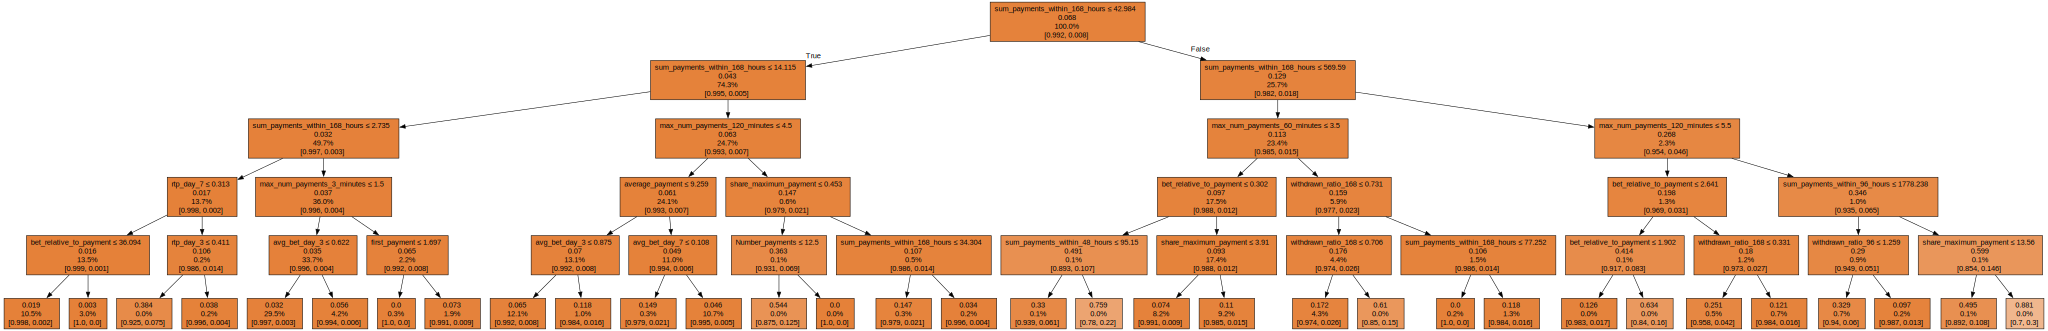

In [94]:
# SHOW ME ONE OF THE TREES

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

# Create the decision tree classifier
clf = model_result['Model'].values[0][0]

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)


- Small bets but some singificant amount of money spent 
- Share maximum payment 
- Withdraw ratio 

In [ ]:
df[['sum_payments_within_48_hours', 'sum_payments_within_168_hours', 'payment_d7']]
print(df[df['sum_payments_within_168_hours'] <= 42.984][df['sum_payments_within_48_hours'] <= 0.653][response].max())
print(df[df['sum_payments_within_168_hours'] <= 42.984][df['sum_payments_within_48_hours'] <= 0.653][response].mean())

1
0.13432835820895522


In [ ]:
# What can be wrong is something with the timings 

df[df["#account_id"] == '10550140'][['sum_payments_within_168_hours', 'payment_d7', 'payment_history', 'payment_history_time', 'first_pay_time', response]]
df[df["#account_id"] == '40180645'][['sum_payments_within_168_hours', 'payment_d7', 'payment_history', 'payment_history_time', 'first_pay_time', response]]

,sum_payments_within_168_hours,payment_d7,payment_history,payment_history_time,first_pay_time,disputes_d30
12730,145.31,29.944,"[18.74, 2.726, 18.74, 47.0, 28.16, 11.204, 18.74]","[""'2024-04-15 11:31:19.176'"", "" '2024-04-16 1...",2024-04-15 11:31:19.176,1


In [ ]:
df[df["#account_id"] == '40180645']['payment_history_time'].values[0]

['"\'2024-04-15 11:31:19.176\'"',
 ' " \'2024-04-16 16:29:44.804\'"',
 ' " \'2024-04-16 17:15:31.605\'"',
 ' " \'2024-04-16 19:22:27.228\'"',
 ' " \'2024-04-16 19:58:55.006\'"',
 ' " \'2024-04-18 05:13:17.117\'"',
 ' " \'2024-04-21 20:53:09.828\'"']

df['sum_withdrawns_within_24_hours ']

### Verification of data and rules

In [74]:
df['sum_withdrawns_within_24_hours ']

KeyError: 'sum_withdrawns_within_24_hours '

In [85]:
# Check payment data 

## Payment and withdraw (Withdrawal bigger than payment) --> Well this makes sense there is no problem at all 
df[df['sum_withdrawns_within_24_hours'] > df['sum_payments_within_24_hours']].shape[0]
df[df['sum_withdrawns_within_24_hours'] > df['sum_payments_within_24_hours']][['sum_withdrawns_within_24_hours', 'sum_payments_within_168_hours', 'payment_d7', 'payment_history', 'payment_history_time', 'first_pay_time', response]]

## Payment over time (it is only one case )
df[df['sum_payments_within_24_hours'] > df['sum_payments_within_168_hours']].shape[0]

## NEgative payments 
df[0 > df['sum_payments_within_168_hours']].shape[0]
df[0 > df['sum_payments_within_24_hours']][['sum_withdrawns_within_24_hours', 'sum_payments_within_168_hours', 'payment_d7', 'payment_history', 'payment_history_time', 'first_pay_time', response]]
df = df[0 <= df['sum_payments_within_24_hours']][0 <= df['sum_payments_within_168_hours']]
df[0 > df['sum_payments_within_168_hours']].shape[0]

## Number of payers 
df.shape[0]

## 

0

In [ ]:
# Verifcation of some combinations obtained 



## Manual analysis of the rules

In [112]:
# Calculate deciles and get the edges
def create_and_plot_pivot_table(df, xlabel, ylabel, aggfunc, title, response_name, y_q, x_q):

    bets_user_quantiles, bets_user_bins = pd.qcut(df[ylabel], y_q, duplicates = 'drop', labels=False, retbins=True)
    concerning_bets_user_quantiles, concerning_bets_user_bins = pd.qcut(df[xlabel], x_q, duplicates = 'drop', labels=False, retbins=True)

    df[f'{xlabel}_quantile'] = concerning_bets_user_quantiles
    df[f'{ylabel}_quantile'] = bets_user_quantiles

    # Create labels for the quantiles
    index_labels = [f'{bets_user_bins[i]:.2f}-{bets_user_bins[i+1]:.2f}' for i in range(len(bets_user_bins)-1)]
    columns_labels = [f'{concerning_bets_user_bins[i]:.2f}-{concerning_bets_user_bins[i+1]:.2f}' for i in range(len(concerning_bets_user_bins)-1)]

    # Create the pivot table
    contingency_table = df.pivot_table(
        index=f'{ylabel}_quantile',
        columns=f'{xlabel}_quantile',
        values=response_name,
        aggfunc=aggfunc
    )

    # Replace quantile numbers with labels
    contingency_table.index = index_labels
    contingency_table.columns = columns_labels

    # Plotting in McKinsey-style format
    plt.figure(figsize=(25, 8))
    sns.heatmap(contingency_table, annot=True, fmt=".3f", cmap="Blues", cbar=True, linewidths=.5)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [ ]:
# If they have not made 

### Maximum payment

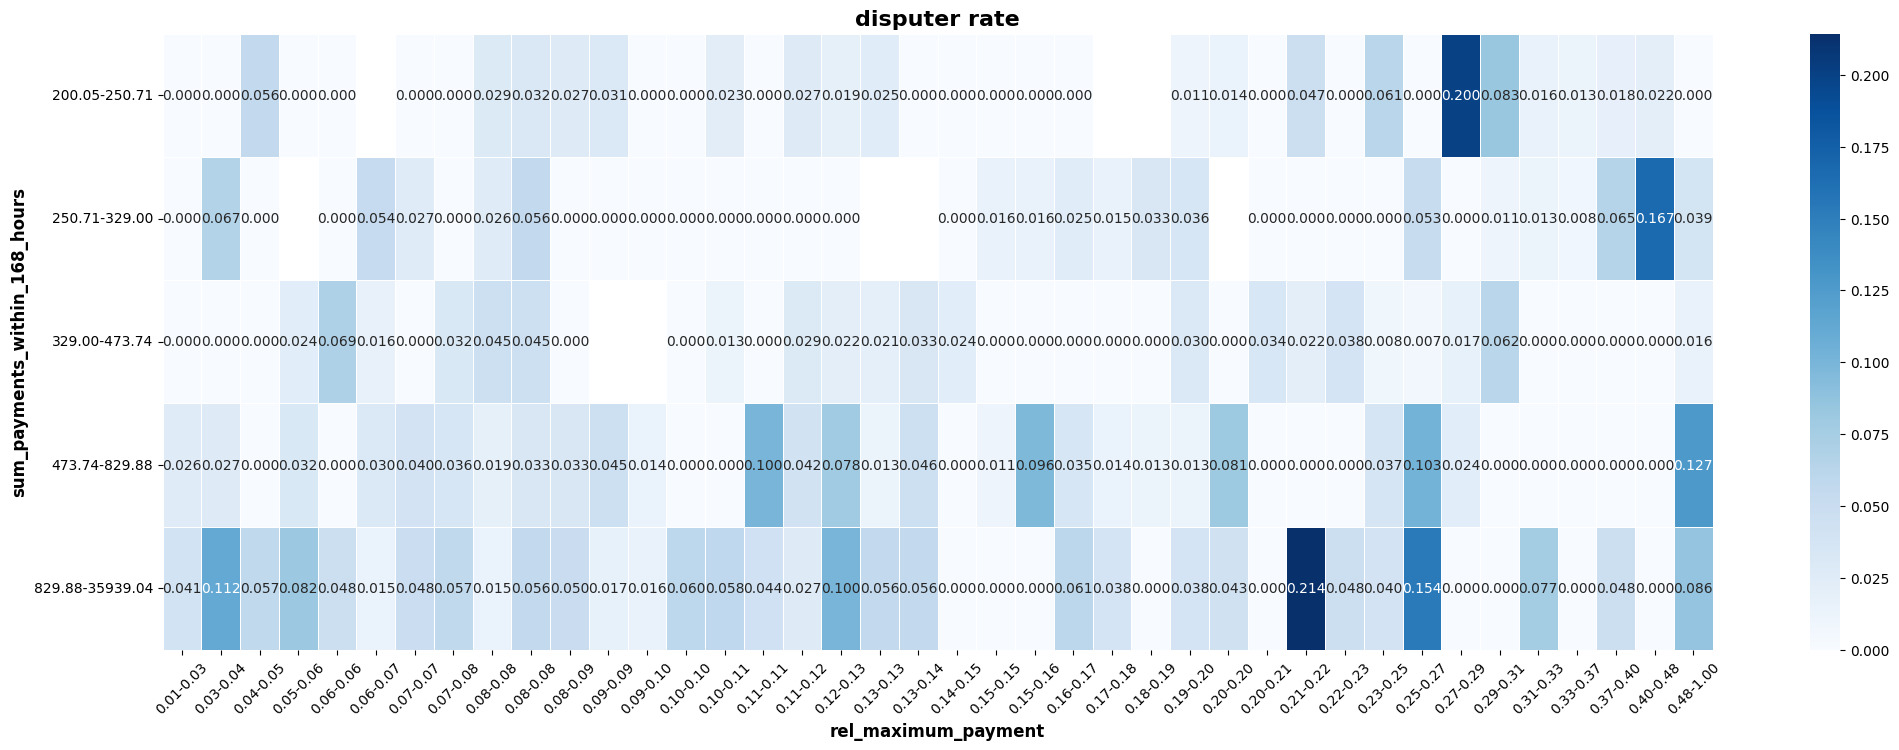

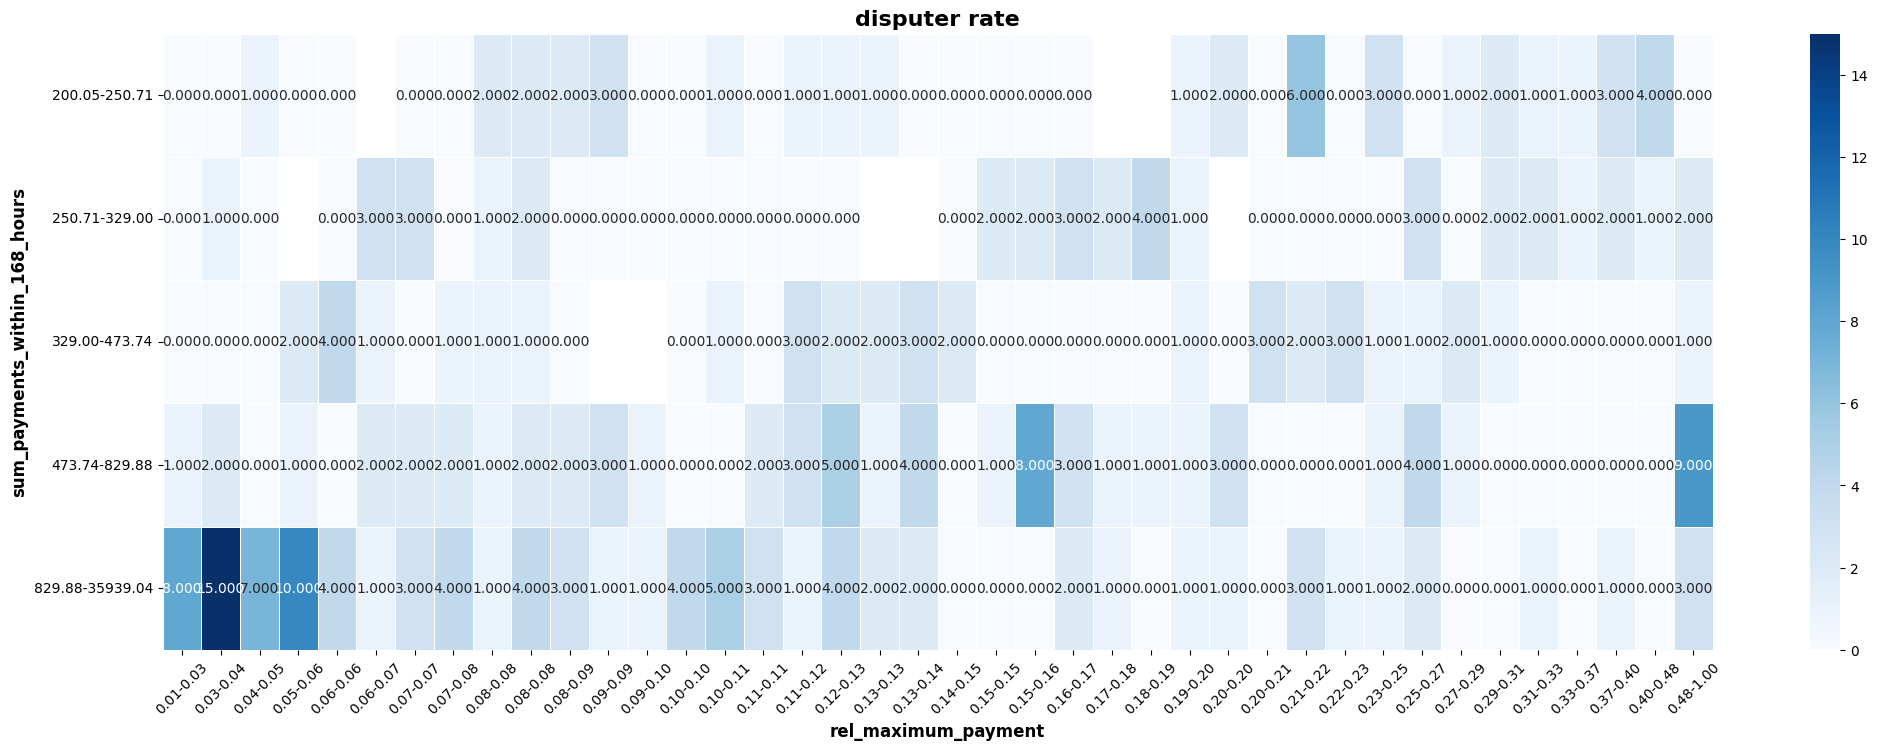

In [113]:
df['rel_maximum_payment'] = df['maximum_payment'] / df['sum_payments_within_168_hours']
ps_df = df[df['sum_payments_within_168_hours'] >= 200]


create_and_plot_pivot_table(ps_df, 'rel_maximum_payment', 'sum_payments_within_168_hours', 'mean', 'disputer rate', response, 5, 40)
create_and_plot_pivot_table(ps_df, 'rel_maximum_payment', 'sum_payments_within_168_hours', 'sum', 'disputer rate' , response, 5, 40)


### Bet and payment combo

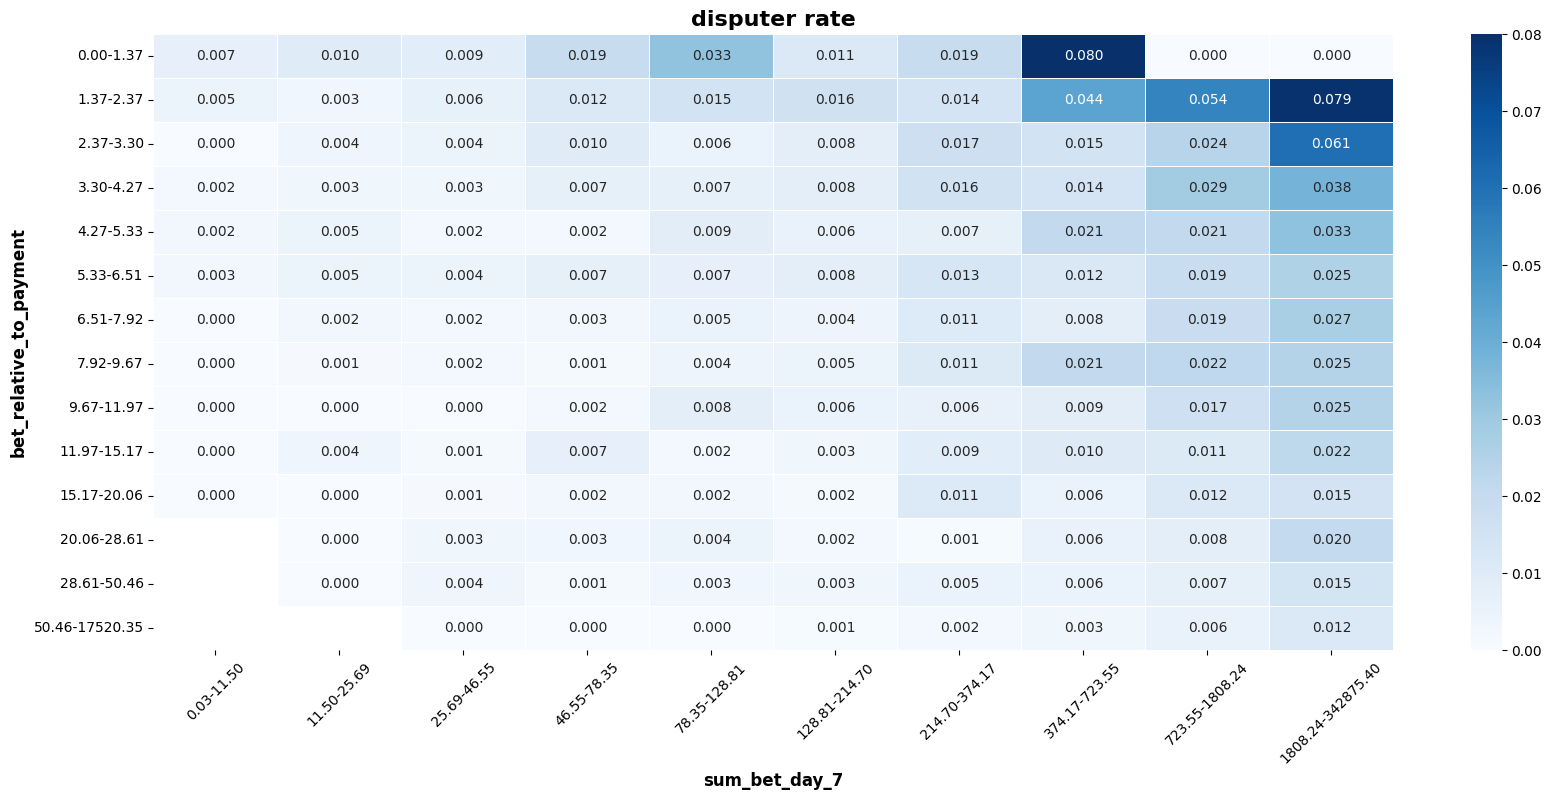

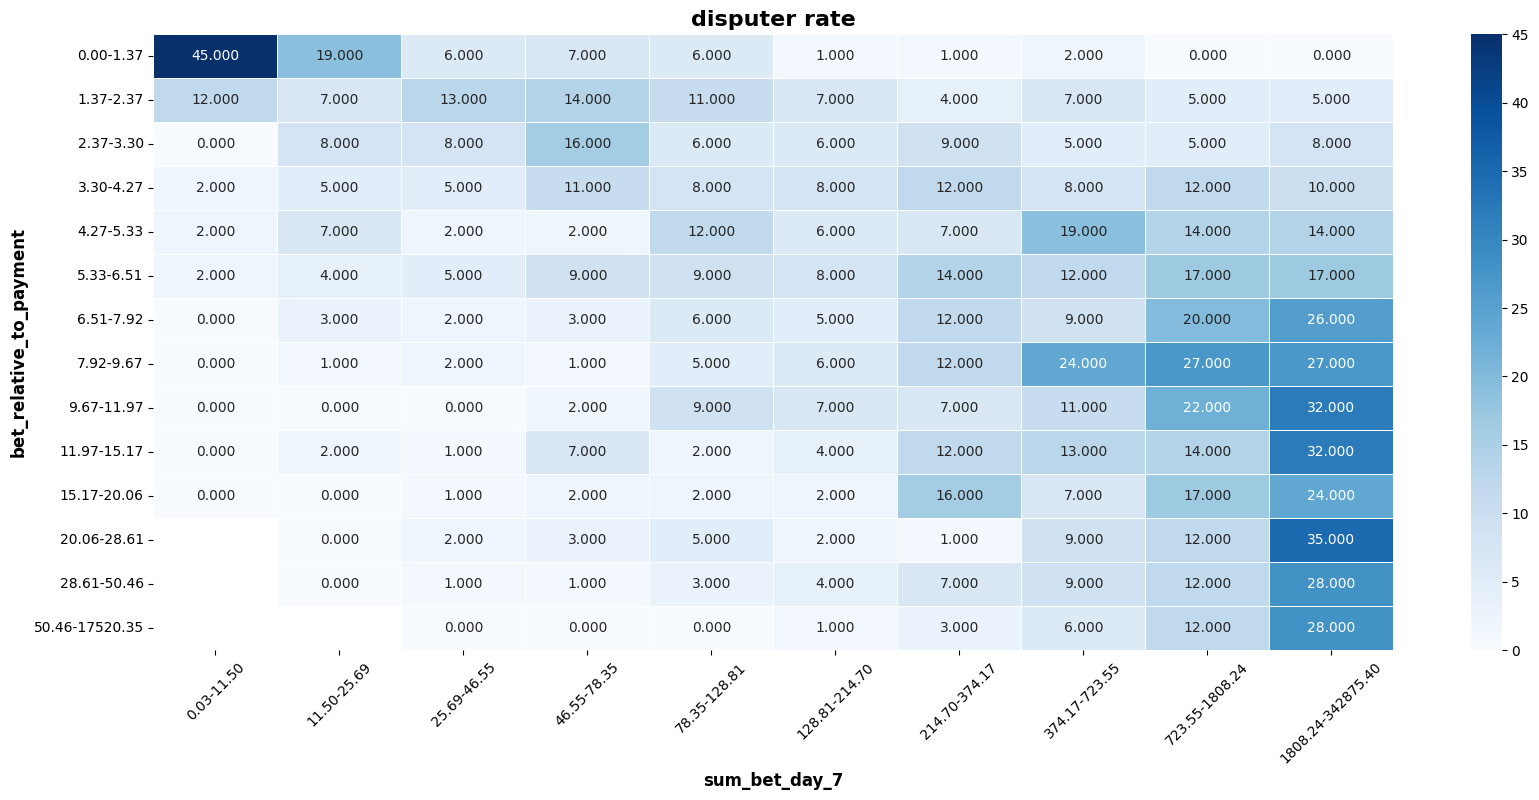

In [97]:
sum_bet_day_7 <= 12
payment_day_7 >= 140


create_and_plot_pivot_table(df, 'sum_bet_day_7', 'bet_relative_to_payment', 'mean', 'disputer rate', response, 14, 10)

create_and_plot_pivot_table(df, 'sum_bet_day_7', 'bet_relative_to_payment', 'sum', 'disputer rate', response, 14, 10)


sum_bet_day_7 <= 12
payment_day_7 >= 140


### Withdrawal combo

- Number of payments in the first minutes 
- ammount withdrawn


So, you can add more payments into account to build the rules 

In [ ]:

x = 'sum_withdrawns_within_96_hours' 
y = 'sum_payments_within_96_hours' 

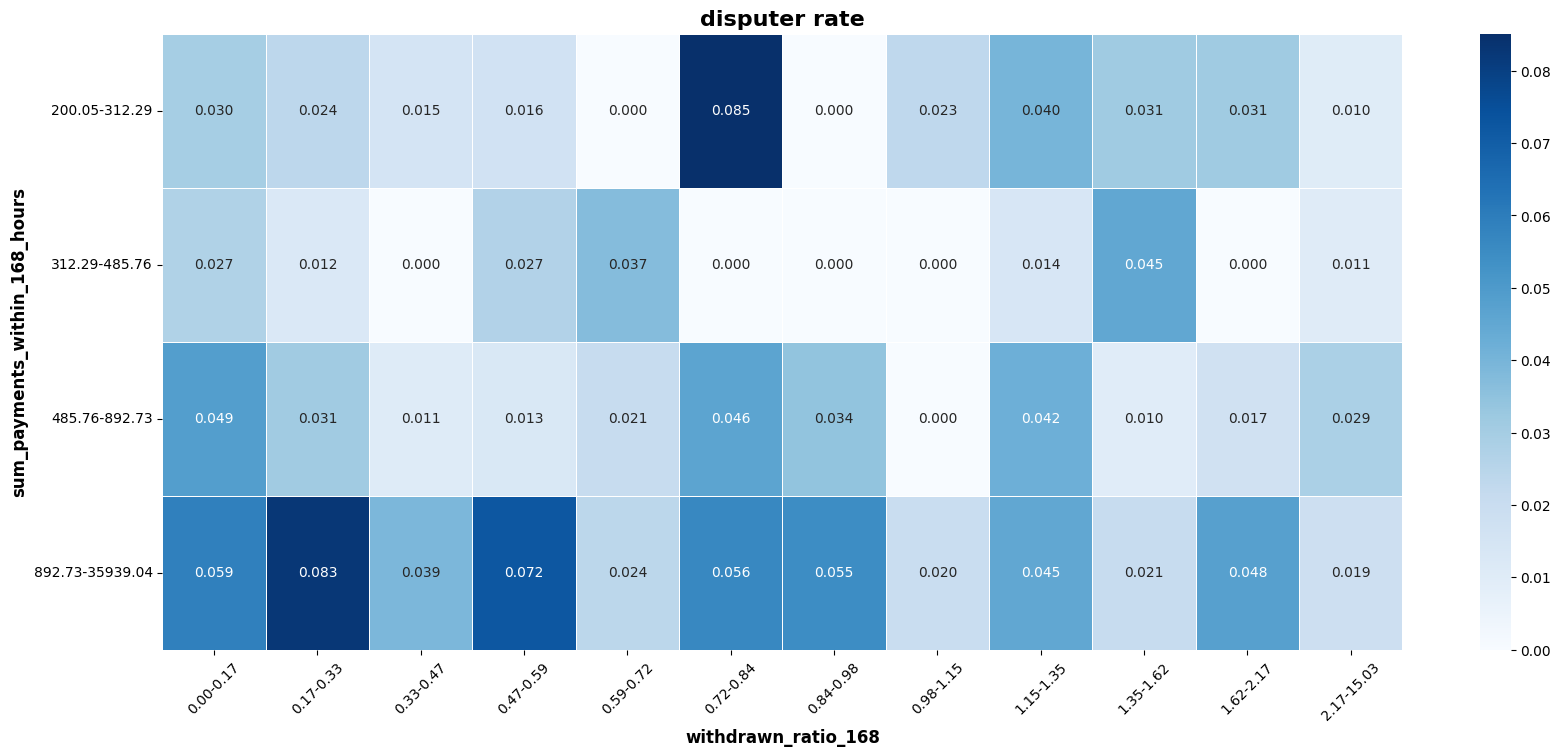

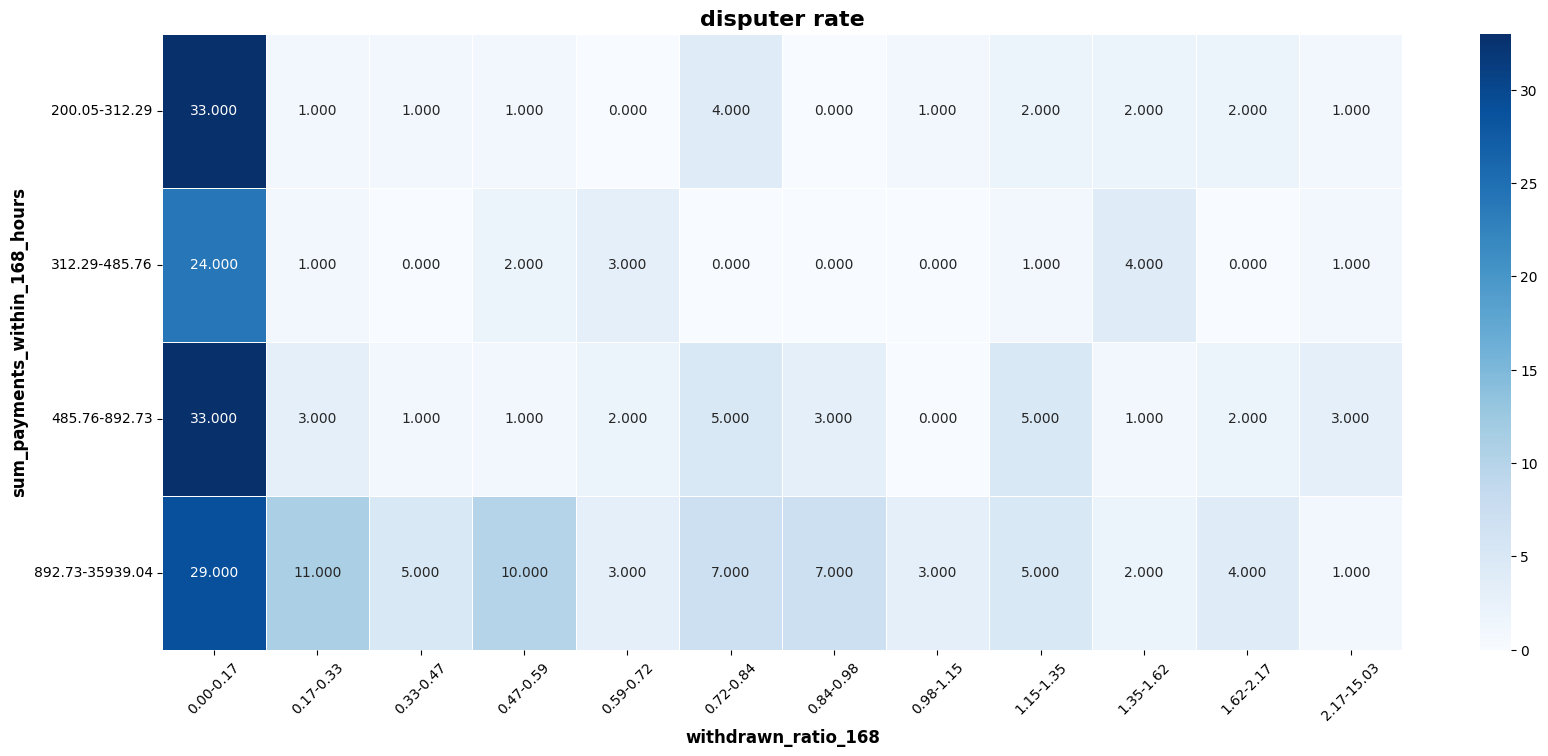

In [ ]:

df_2 = df[df['sum_payments_within_96_hours'] > 200]


create_and_plot_pivot_table(df_2, 'withdrawn_ratio_168', 'sum_payments_within_168_hours', 'mean', 'disputer rate', response, 4, 20)
create_and_plot_pivot_table(df_2, 'withdrawn_ratio_168', 'sum_payments_within_168_hours', 'sum', 'disputer rate', response, 4, 20)


# Payment concentration

In [183]:
df[df['rel_maximum_payment'] > 1][['rel_maximum_payment', 'maximum_payment', 'sum_payments_within_168_hours']]

df['rel_maximum_payment'] = df['maximum_payment'] / df['sum_payments_within_168_hours']
df[df['rel_maximum_payment'] > 1][['rel_maximum_payment', 'maximum_payment', 'sum_payments_within_168_hours']]


,rel_maximum_payment,maximum_payment,sum_payments_within_168_hours
72068,4.237212,94.1,22.208


In [184]:
# Select appropiate betting columns

bet_columns = [col for col in df.columns if 'max' in col]
bet_columns


['max_bet',
 'max_bet_day_1',
 'max_bet_day_3',
 'max_bet_day_7',
 'max_day_1',
 'max_day_3',
 'max_day_7',
 'maximum_payment',
 'rel_maximum_payment',
 'max_num_payments_2_minutes',
 'max_num_payments_3_minutes',
 'max_num_payments_5_minutes',
 'max_num_payments_10_minutes',
 'max_num_payments_30_minutes',
 'max_num_payments_60_minutes',
 'max_num_payments_120_minutes',
 'share_maximum_payment',
 'maximum_payment_quantile',
 'rel_maximum_payment_quantile']

In [106]:
df[df['rel_maximum_payment'] > 1][['rel_maximum_payment', 'maximum_payment', 'sum_payments_within_168_hours']]


,rel_maximum_payment,maximum_payment,sum_payments_within_168_hours
0,3.971694,95.3000,1559.66200
1,3.019585,18.8200,24.93058
2,1.203838,18.8200,46.90000
3,1.567836,9.3200,71.33400
4,1.528027,2.7260,3.56800
...,...,...,...
140239,1.504013,18.7400,37.38000
140240,2.031207,94.1000,324.29000
140241,1.676515,11.3492,67.69520
140242,1.243408,4.4800,7.20600


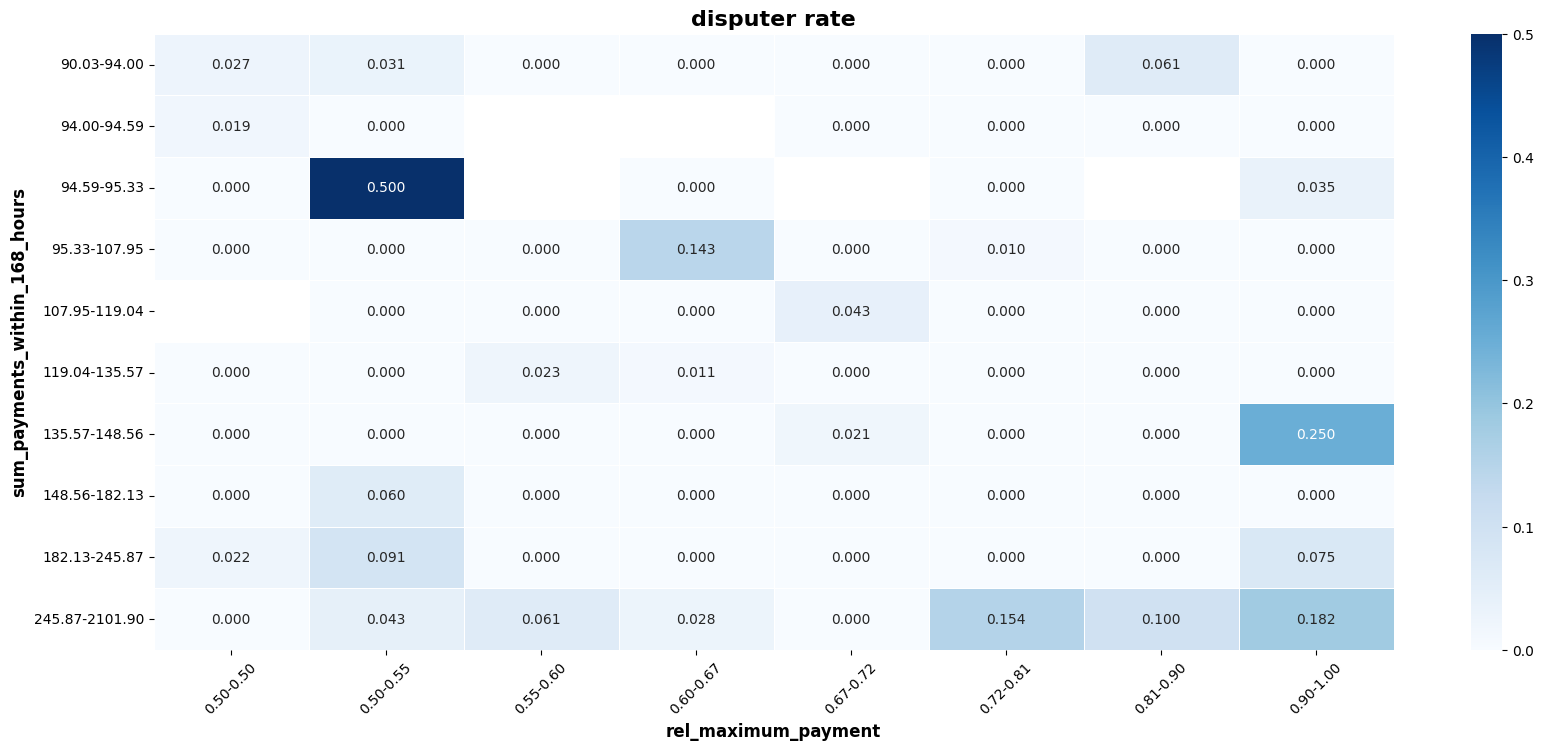

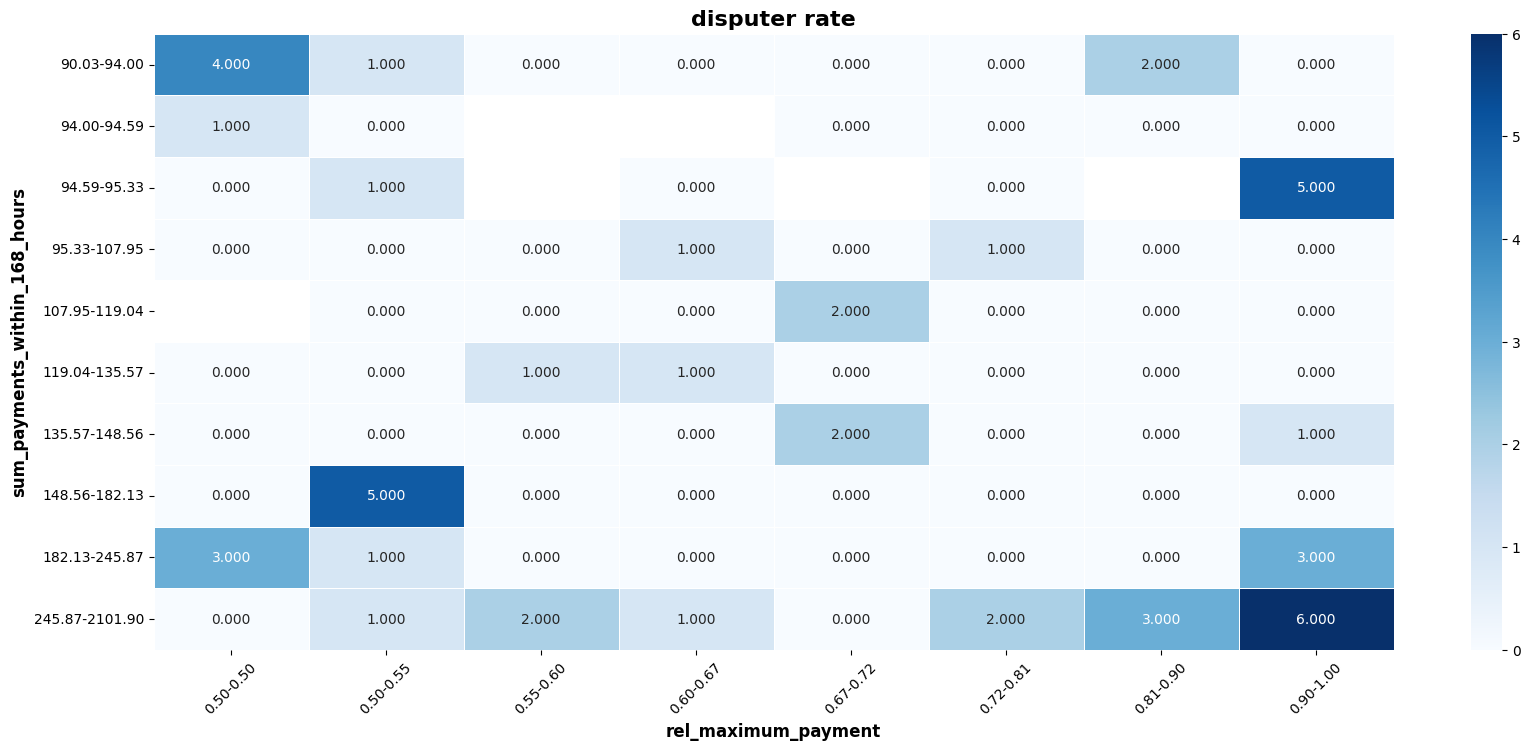

In [191]:

# create_and_plot_pivot_table(df, 'maximum_payment', 'sum_payments_within_168_hours', 'mean', 'disputer rate', response, 10, 10)
# create_and_plot_pivot_table(df, 'maximum_payment', 'sum_payments_within_168_hours', 'sum', 'disputer rate', response, 10, 10)

df_aux = df[df['rel_maximum_payment'] >= 0.5][df['sum_payments_within_168_hours'] >= 90]

create_and_plot_pivot_table(df_aux, 'rel_maximum_payment', 'sum_payments_within_168_hours', 'mean', 'disputer rate', response, 10, 10)
create_and_plot_pivot_table(df_aux, 'rel_maximum_payment', 'sum_payments_within_168_hours', 'sum', 'disputer rate', response, 10, 10)


In [192]:
df['win_day_1']

KeyError: 'win_day_1'